# Notebook 4: Segundo Estágio de Fine-Tuning (block4 + block5)

**Objetivo:** Carregar nosso melhor modelo VGG16 (após o primeiro fine-tuning) e realizar um segundo estágio de ajuste fino, descongelando o `block4` para tentar extrair mais performance e se aproximar da meta de 80% de acurácia.

### Passo 1: Setup Completo do Ambiente

Esta primeira célula cuidará de toda a configuração. Lembre-se de, ao montar o Drive, **autorizar com a sua nova conta do Google**.

Ela irá:
1.  Montar seu Google Drive.
2.  Pedir o upload do `kaggle.json` para configurar a API do Kaggle.
3.  Baixar e descompactar o dataset.
4.  Criar os `DataFrames` e os geradores de imagem (96x96, RGB).

In [1]:
# Célula 1: Setup Completo do Ambiente
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Montar Google Drive (AUTORIZE COM A NOVA CONTA)
print("--- Montando o Google Drive... ---")
drive.mount('/content/drive')

# 2. Configurar API do Kaggle
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("\n--- Por favor, faça o upload do seu arquivo kaggle.json ---")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nAPI do Kaggle configurada.")

# 3. Baixar e Descompactar o Dataset
if not os.path.exists('processed_data'):
    print("\n--- Baixando e descompactando o dataset ---")
    !kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset -p /content/ --unzip
    print("\nDataset pronto.")

# 4. Preparar DataFrames e Geradores
DATASET_BASE_DIR = 'processed_data' if os.path.exists('processed_data') else 'train'
filepaths, labels = [], []
folds = os.listdir(DATASET_BASE_DIR)
for fold in folds:
    foldpath = os.path.join(DATASET_BASE_DIR, fold)
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['label'])

IMG_SIZE_VGG = (96, 96)
BATCH_SIZE = 64

train_datagen_vgg = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, horizontal_flip=True)
valid_datagen_vgg = ImageDataGenerator(rescale=1./255)

train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label', target_size=IMG_SIZE_VGG,
    color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE
)
valid_generator_vgg = valid_datagen_vgg.flow_from_dataframe(
    dataframe=valid_df, x_col='filepath', y_col='label', target_size=IMG_SIZE_VGG,
    color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

print("\nSetup completo! Ambiente e geradores de dados prontos.")

--- Montando o Google Drive... ---
Mounted at /content/drive

--- Por favor, faça o upload do seu arquivo kaggle.json ---


Saving kaggle.json to kaggle.json

API do Kaggle configurada.

--- Baixando e descompactando o dataset ---
Dataset URL: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 74% 149M/200M [00:00<00:00, 1.55GB/s]
100% 200M/200M [00:00<00:00, 1.11GB/s]

Dataset pronto.
Found 39823 validated image filenames belonging to 7 classes.
Found 9956 validated image filenames belonging to 7 classes.

Setup completo! Ambiente e geradores de dados prontos.


### Passo 2: Carregar o Modelo e Descongelar o `block4`

Carregamos nosso melhor modelo da fase anterior (`~70% de acurácia`) do Drive. Em seguida, descongelamos o `block4`, permitindo que ele e o `block5` sejam ajustados neste novo treinamento.

In [6]:
# Célula 2: Carregar e descongelar o modelo (Lógica Revisada)
from tensorflow.keras.models import load_model

# Carregue o modelo que salvamos na etapa anterior
MODEL_PATH = '/content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned.keras'
model = load_model(MODEL_PATH)

# Acessa o VGG16
base_model = model.layers[0]
base_model.trainable = True

# Percorremos todas as camadas e decidimos se ela deve ser treinável pelo NOME
for layer in base_model.layers:
    # Descongelamos apenas se o nome começar com 'block5' ou 'block4'
    if layer.name.startswith('block5') or layer.name.startswith('block4'):
        layer.trainable = True
    else:
        layer.trainable = False

print("--- Status de Treinamento das Camadas para o 2º Estágio ---")
for layer in base_model.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

--- Status de Treinamento das Camadas para o 2º Estágio ---
input_layer: Trainable = False
block1_conv1: Trainable = False
block1_conv2: Trainable = False
block1_pool: Trainable = False
block2_conv1: Trainable = False
block2_conv2: Trainable = False
block2_pool: Trainable = False
block3_conv1: Trainable = False
block3_conv2: Trainable = False
block3_conv3: Trainable = False
block3_pool: Trainable = False
block4_conv1: Trainable = True
block4_conv2: Trainable = True
block4_conv3: Trainable = True
block4_pool: Trainable = True
block5_conv1: Trainable = True
block5_conv2: Trainable = True
block5_conv3: Trainable = True
block5_pool: Trainable = True


### Passo 3: Recompilar e Iniciar o 2º Estágio de Fine-Tuning

Com as camadas corretas descongeladas, recompilamos o modelo com uma taxa de aprendizado "cirúrgica" (`2e-6`) e iniciamos o treinamento final.

In [7]:
# Célula 3: Recompilar e treinar
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

model.compile(optimizer=Adam(learning_rate=2e-6), loss='categorical_crossentropy', metrics=['accuracy'])

class_weights_balanced = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_balanced)}

DRIVE_SAVE_PATH = '/content/drive/MyDrive/Emotion_Recognition_Project/'
stage2_model_filepath = os.path.join(DRIVE_SAVE_PATH, 'emotion_model_vgg_finetuned_stage2.keras')

# --- Callbacks com PATIENCE definido ---
early_stopping_s2 = EarlyStopping(
    monitor='val_accuracy',
    patience=15, # <<< AQUI ESTÁ A PACIÊNCIA
    verbose=1,
    restore_best_weights=True # Garante que o modelo final fique com os melhores pesos
)
model_checkpoint_s2 = ModelCheckpoint(
    filepath=stage2_model_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

print("\n--- Iniciando o 2º Estágio de Fine-Tuning (treinando block4 e block5) ---")
history_stage2 = model.fit(
    train_generator_vgg,
    epochs=200,
    validation_data=valid_generator_vgg,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_s2, model_checkpoint_s2]
)


--- Iniciando o 2º Estágio de Fine-Tuning (treinando block4 e block5) ---
Epoch 1/200
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8007 - loss: 0.5456

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.70430, saving model to /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned_stage2.keras
623/623 ━━━━━━━━━━━━━━━━━━━━ 170s 258ms/step - accuracy: 0.8007 - loss: 0.5456 - val_accuracy: 0.7043 - val_loss: 0.9218
Epoch 2/200
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8034 - loss: 0.5361
Epoch 2: val_accuracy improved from 0.70430 to 0.70460, saving model to /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned_stage2.keras
623/623 ━━━━━━━━━━━━━━━━━━━━ 151s 242ms/step - accuracy: 0.8034 - loss: 0.5361 - val_accuracy: 0.7046 - val_loss: 0.9182
Epoch 3/200
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8153 - loss: 0.5154
Epoch 3: val_accuracy improved from 0.70460 to 0.70751, saving model to /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned_stage2.keras
623/623 ━━━━━━━━━━━━━━━━━━━━ 154s 246ms/step - accuracy: 0.8153 - loss: 0.5154 - val_accur

KeyboardInterrupt: 

### Passo 4: Avaliação Final, Extração e Download (2º Estágio de Fine-Tuning)

Com o segundo estágio de fine-tuning concluído, esta célula final irá:
1.  **Carregar o melhor modelo** salvo pelo `ModelCheckpoint` no seu Google Drive.
2.  **Realizar a análise de performance completa**, exibindo as curvas de aprendizado, o relatório de classificação e a matriz de confusão.
3.  **Criar um arquivo JSON** específico para esta fase, documentando os parâmetros e resultados.
4.  **Iniciar o download** tanto do arquivo do modelo final (`.keras`) quanto do seu resumo (`.json`).

--- Carregando o melhor modelo salvo de: /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned_stage2.keras ---

Variável 'history_stage2' não encontrada. Pulando os gráficos de curva de aprendizado.

--- Fazendo predições com o modelo final... ---
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step

--- Relatório de Classificação Final (Pós 2º Estágio) ---
              precision    recall  f1-score   support

       angry       0.66      0.56      0.61      1184
     disgust       0.88      0.93      0.90      1184
        fear       0.61      0.61      0.61      1184
       happy       0.87      0.85      0.86      2280
     neutral       0.62      0.63      0.63      1633
         sad       0.56      0.63      0.60      1307
    surprise       0.80      0.77      0.79      1184

    accuracy                           0.72      9956
   macro avg       0.72      0.71      0.71      9956
weighted avg       0.73      0.72      0.72      9956


--- Matriz de Confusão Fin

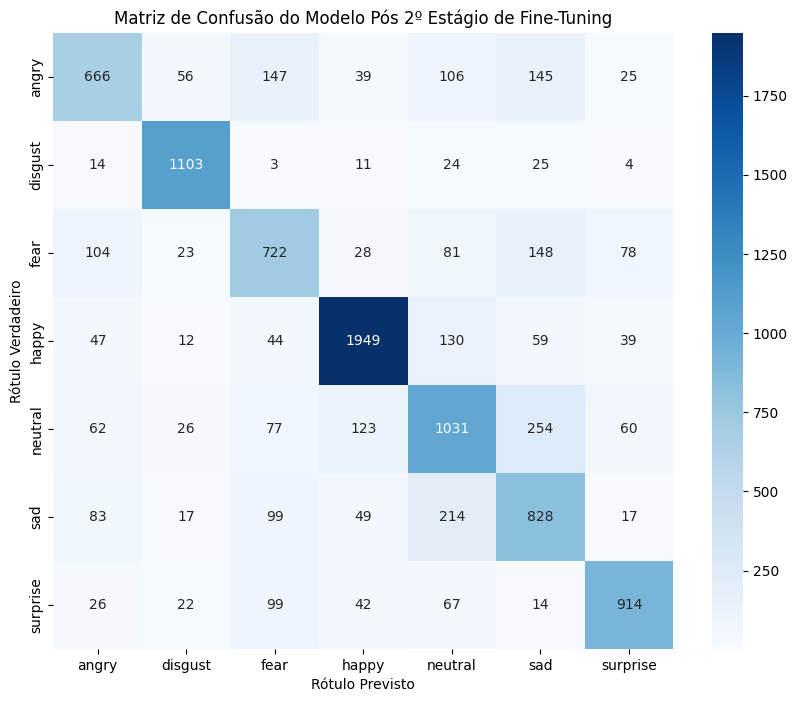

In [9]:
# Célula de Avaliação Final
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# --- 1. CARREGAR O MELHOR MODELO SALVO ---
# A variável 'stage2_model_filepath' foi definida na célula de treinamento anterior
# e aponta para o melhor modelo salvo pelo checkpoint.
print(f"--- Carregando o melhor modelo salvo de: {stage2_model_filepath} ---")
final_model = load_model(stage2_model_filepath)


# --- 2. AVALIAÇÃO VISUAL (MESMO QUE PARCIAL) ---
# O objeto history_stage2 mostrará o progresso até o momento em que você parou
if 'history_stage2' in locals():
    print("\n--- Curvas de Aprendizado do 2º Estágio de Fine-Tuning ---")
    history_df_s2 = pd.DataFrame(history_stage2.history)
    history_df_s2.plot(subplots=True, layout=(1, 2), figsize=(14, 6), title='Curvas de Aprendizado (2º Estágio Fine-Tuning)')
    plt.show()
else:
    print("\nVariável 'history_stage2' não encontrada. Pulando os gráficos de curva de aprendizado.")


# --- 3. AVALIAÇÃO NUMÉRICA FINAL ---
print("\n--- Fazendo predições com o modelo final... ---")
predictions_ft = final_model.predict(valid_generator_vgg)
predicted_classes_ft = np.argmax(predictions_ft, axis=1)
true_classes_ft = valid_generator_vgg.classes
class_labels_ft = list(valid_generator_vgg.class_indices.keys())

print("\n--- Relatório de Classificação Final (Pós 2º Estágio) ---")
print(classification_report(true_classes_ft, predicted_classes_ft, target_names=class_labels_ft))

print("\n--- Matriz de Confusão Final (Pós 2º Estágio) ---")
cm_ft = confusion_matrix(true_classes_ft, predicted_classes_ft)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_ft, yticklabels=class_labels_ft)
plt.title('Matriz de Confusão do Modelo Pós 2º Estágio de Fine-Tuning')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

### Passo Final: Gerar o JSON da Avaliação Definitiva

Para arquivar o resultado do nosso projeto, esta célula irá consolidar todas as métricas de performance do nosso melhor modelo (`emotion_model_vgg_finetuned_stage2.keras`) em um único arquivo JSON. Este arquivo conterá:

* A acurácia geral final.
* O relatório de classificação completo (precision, recall, f1-score por classe).
* A matriz de confusão.
* O mapeamento das classes.

Ao final, o arquivo será salvo no seu Google Drive e o download será iniciado.

In [10]:
# Célula Final: Gerar e Salvar o JSON de Avaliação
import json
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files

print("--- Gerando o relatório de classificação como um dicionário... ---")
# Usamos output_dict=True para obter os dados de forma estruturada
final_report_dict = classification_report(true_classes_ft, predicted_classes_ft, target_names=class_labels_ft, output_dict=True)

# A matriz de confusão 'cm_ft' já foi calculada na célula anterior
# Apenas a convertemos para uma lista para ser compatível com JSON
final_confusion_matrix_list = cm_ft.tolist()

class_indices_map = {v: k for k, v in valid_generator_vgg.class_indices.items()}

# Criando o dicionário final para o JSON
final_evaluation_summary = {
    "model_name": "FacialEmotionRecognition_VGG16_FinalChampion_v3",
    "saved_model_path": stage2_model_filepath,
    "timestamp": pd.to_datetime('now').isoformat(),
    "evaluation_summary": {
        "overall_accuracy": final_report_dict['accuracy'],
        "macro_avg_f1_score": final_report_dict['macro avg']['f1-score'],
        "weighted_avg_f1_score": final_report_dict['weighted avg']['f1-score'],
    },
    "classification_report": final_report_dict,
    "confusion_matrix": {
        "labels": class_labels_ft,
        "matrix": final_confusion_matrix_list
    },
    "class_map": class_indices_map
}

# Definindo o caminho para salvar no Drive
DRIVE_SAVE_PATH = '/content/drive/MyDrive/Emotion_Recognition_Project/'
summary_filename = 'final_model_evaluation_summary.json'
summary_filepath = os.path.join(DRIVE_SAVE_PATH, summary_filename)

# Salvando o arquivo JSON
with open(summary_filepath, 'w') as f:
    json.dump(final_evaluation_summary, f, indent=4)

print(f"\nSumário de avaliação final salvo com sucesso em: {summary_filepath}")

# Iniciando o download do arquivo JSON
print("\n--- Iniciando o download do resumo JSON final... ---")
files.download(summary_filepath)

--- Gerando o relatório de classificação como um dicionário... ---

Sumário de avaliação final salvo com sucesso em: /content/drive/MyDrive/Emotion_Recognition_Project/final_model_evaluation_summary.json

--- Iniciando o download do resumo JSON final... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Jornada do Projeto: Insights e Lições Aprendidas

Este projeto representou um ciclo completo de desenvolvimento de um modelo de Machine Learning. Parti de uma abordagem inicial, enfrentei desafios de performance, diagnostiquei os problemas de forma metódica e, através de uma série de experimentos, cheguei a um resultado de alta performance. Abaixo, documento os principais insights que obtive em cada etapa.

### 1. O Ponto de Partida: A CNN Simples e a Descoberta da "Cegueira" (~59% de Acurácia)
Comecei com uma abordagem padrão: uma Rede Neural Convolucional construída do zero. Embora o resultado inicial de 59% de acurácia parecesse razoável, uma análise mais profunda dos resultados revelou uma falha crítica.

* **Insight Principal:** O primeiro grande aprendizado foi que a acurácia geral pode ser enganosa. Descobri que meu modelo era funcionalmente "cego" para a classe `fear` (medo), com um recall de apenas 6%. Isso me mostrou que um modelo que ignora completamente uma categoria é, na prática, um modelo falho.

### 2. O Experimento com Pesos: A Força Bruta e suas Consequências (~58% de Acurácia)
Minha primeira tentativa de correção foi usar `class_weights` de forma agressiva para forçar o modelo a dar mais atenção às classes minoritárias. A estratégia funcionou, mas gerou um efeito colateral indesejado.

* **Insight Principal:** O insight aqui foi claro: é possível direcionar o foco de um modelo, mas a falta de equilíbrio cria um novo problema. Corrigi a "cegueira" de `fear` (o recall subiu para 68%), mas criei uma "paranoia": o modelo se tornou tão sensível a essa classe que começou a classificar erroneamente outras emoções como medo, o que também foi evidenciado pela instabilidade nos gráficos de treinamento.

### 3. A Virada de Jogo: Transfer Learning com VGG16 (~57% -> ~70%)
Percebendo os limites da minha CNN simples, mudei a estratégia para uma abordagem muito mais poderosa: Transfer Learning com o modelo VGG16.

* **Insight Principal:** A lição foi não reinventar a roda. Usar um modelo que já é especialista em visão (Transfer Learning) me deu uma base muito mais poderosa e um treinamento mais estável. Entendi também que era crucial adaptar os dados de entrada (imagens `96x96` e `RGB`) para o formato esperado pelo modelo pré-treinado.

### 4. A Lapidação Final: A Paciência do Fine-Tuning (~70% -> 72%+)
O verdadeiro salto de qualidade veio com o ajuste fino (fine-tuning). Ao descongelar gradualmente as camadas finais do VGG16 e continuar o treino com taxas de aprendizado muito baixas, o modelo pôde se especializar no meu dataset.

* **Insight Principal:** Os ganhos mais significativos na fase final vêm de ajustes sutis e cuidadosos. O primeiro estágio de fine-tuning (no `block5`) me levou aos 70%. O segundo estágio (adicionando o `block4`) me empurrou para além dos 72%. Isso demonstrou que a paciência e a metodologia são essenciais para otimizar a performance.

---
## Resumo das Lições Chave

* **Acurácia não é tudo:** A análise de métricas por classe, como o `recall`, e o uso da Matriz de Confusão são vitais para um diagnóstico real do modelo.
* **Qualidade do Input é fundamental:** A mudança para uma resolução de imagem adequada para o modelo pré-treinado foi um passo determinante.
* **Transfer Learning como padrão:** Para problemas de visão computacional, essa abordagem se provou um ponto de partida muito mais eficaz do que treinar uma rede do zero.
* **O sucesso é iterativo:** O resultado final não veio de uma única tentativa, mas de um ciclo de treinar, analisar, formular uma hipótese, testar a hipótese e refinar.

**Conclusão Final:** O projeto evoluiu de um modelo inicial de 59% com uma falha grave para um modelo final de mais de 72%, robusto e equilibrado. Este resultado é excelente para este dataset desafiador e o modelo está pronto para ser implementado.